In [1]:
import pandas as pd
import numpy as np
import time
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
import joblib

In [2]:
# Cargar los datos
cleaned_data_path = '../datasets/cleaned_data.csv'
data_all = pd.read_csv(cleaned_data_path)

C:\Users\Ketbome\AppData\Local\Temp\ipykernel_18132\909222528.py:3: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  data_all = pd.read_csv(cleaned_data_path)


In [3]:
# solo dejar los que en COD_ENSE 110, 310, 360, 410, 510, 610, 710, 910
data_clear = data_all[data_all['COD_ENSE'].isin([110, 310, 360, 410, 510, 610, 710, 910])]

In [4]:
# Asegúrate de que 'COD_ENSE' y 'COD GRADO' sean interpretados como listas en la condición
def asignar_curso(row):
    if row['COD_ENSE'] == 110:
        return row['COD_GRADO']
    elif row['COD_ENSE'] in [310,360, 410, 510, 610, 710, 810, 910]:
        return row['COD_GRADO'] + 8
    else:
        return None

# Aplica la función a cada fila (axis=1) y crea la nueva columna 'Curso'
data_new = data_clear.apply(asignar_curso, axis=1)

In [5]:
# solo dejar los que en COD_TIP_CUR 0 de la data_all
data_clear = data_clear[data_clear['COD_TIP_CUR'].isin([0])]

# solo dejar los COD_JOR 1, 2 y 3
data_clear = data_clear[data_clear['COD_JOR'].isin([3])]

# Solo dejar genero masculino y femenino
data_clear = data_clear[data_clear['GEN_ALU'].isin([1, 2])]

# Solo dejar COD_DEPE2 1 2 3
data_clear = data_clear[data_clear['COD_DEPE2'].isin([1, 2, 3])]

# Solo dejar COD_ENSE2 2, 5 y 7
data_clear = data_clear[data_clear['COD_ENSE2'].isin([2, 5, 7])]


In [6]:
# Cuenta las ocurrencias de cada valor en 'COD_COM_RBD'
counts = data_clear['COD_COM_RBD'].value_counts()

# Crea una máscara donde cada valor es True si el conteo correspondiente es mayor a 1000
mask = data_clear['COD_COM_RBD'].isin(counts[counts > 1000].index)

# Aplica la máscara para filtrar el DataFrame
data_clear = data_clear[mask]

In [7]:
# agregar la columna 'Curso' a data_all
data_clear['CURSO'] = data_new

In [8]:
# Convertir la columna a números, los valores inválidos se convierten en NaN
data_clear['EDAD_ALU'] = pd.to_numeric(data_clear['EDAD_ALU'], errors='coerce')

# Eliminar las filas con NaN en la columna 'EDAD_ALU'
data_clear = data_clear.dropna(subset=['EDAD_ALU'])

In [9]:
data_clear.head()

,ï»¿AGNO,RBD,DGV_RBD,NOM_RBD,COD_REG_RBD,NOM_REG_RBD_A,COD_PRO_RBD,COD_COM_RBD,NOM_COM_RBD,COD_DEPROV_RBD,...,NOM_COM_ALU,COD_RAMA,COD_SEC,COD_ESPE,PROM_GRAL,ASISTENCIA,SIT_FIN,SIT_FIN_R,COD_MEN,CURSO
14453,2022,45,0,COLEGIO ITALIANO SANTA ANA,15,AYP,151,15101,ARICA,151,...,SAN RAMÃN,0,0,0,6.8,95,P,P,0,1
14454,2022,45,0,COLEGIO ITALIANO SANTA ANA,15,AYP,151,15101,ARICA,151,...,SANTIAGO,0,0,0,6.7,85,P,P,0,1
14455,2022,45,0,COLEGIO ITALIANO SANTA ANA,15,AYP,151,15101,ARICA,151,...,ARICA,0,0,0,6.7,98,P,P,0,1
14456,2022,45,0,COLEGIO ITALIANO SANTA ANA,15,AYP,151,15101,ARICA,151,...,SANTIAGO,0,0,0,6.5,88,P,P,0,1
14457,2022,45,0,COLEGIO ITALIANO SANTA ANA,15,AYP,151,15101,ARICA,151,...,SANTIAGO,0,0,0,6.4,96,P,P,0,1


In [10]:
# Eliminar columnas
data = data_clear.drop(['ï»¿AGNO', 'ESTADO_ESTAB','COD_DEPE','COD_DEPROV_RBD', 'RBD', 'NOM_RBD', 'NOM_REG_RBD_A', 'NOM_COM_RBD', 'NOM_DEPROV_RBD', 'LET_CUR', 'NOM_COM_ALU', 'SIT_FIN', 'SIT_FIN_R', 'COD_ENSE', 'COD_GRADO', 'DGV_RBD', 'COD_PRO_RBD', 'COD_TIP_CUR', 'COD_DES_CUR', 'MRUN', 'FEC_NAC_ALU', 'COD_RAMA', 'COD_SEC', 'COD_ESPE', 'COD_MEN', 'COD_JOR'], axis=1)

In [11]:
# Borrar las filas donde la columna 'COD_SEC' sea distinto de 0
data = data[data_all['COD_SEC'] == 0]  # Solo alumnos de basica y media

C:\Users\Ketbome\AppData\Local\Temp\ipykernel_18132\4024889077.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[data_all['COD_SEC'] == 0]  # Solo alumnos de basica y media


In [12]:
data.head()

,COD_REG_RBD,COD_COM_RBD,COD_DEPE2,RURAL_RBD,COD_ENSE2,GEN_ALU,EDAD_ALU,COD_REG_ALU,COD_COM_ALU,PROM_GRAL,ASISTENCIA,CURSO
14453,15,15101,2,0,2,2,7.0,13,13131,6.8,95,1
14454,15,15101,2,0,2,2,7.0,13,13101,6.7,85,1
14455,15,15101,2,0,2,2,7.0,15,15101,6.7,98,1
14456,15,15101,2,0,2,2,7.0,13,13101,6.5,88,1
14457,15,15101,2,0,2,2,7.0,13,13101,6.4,96,1


<Axes: >

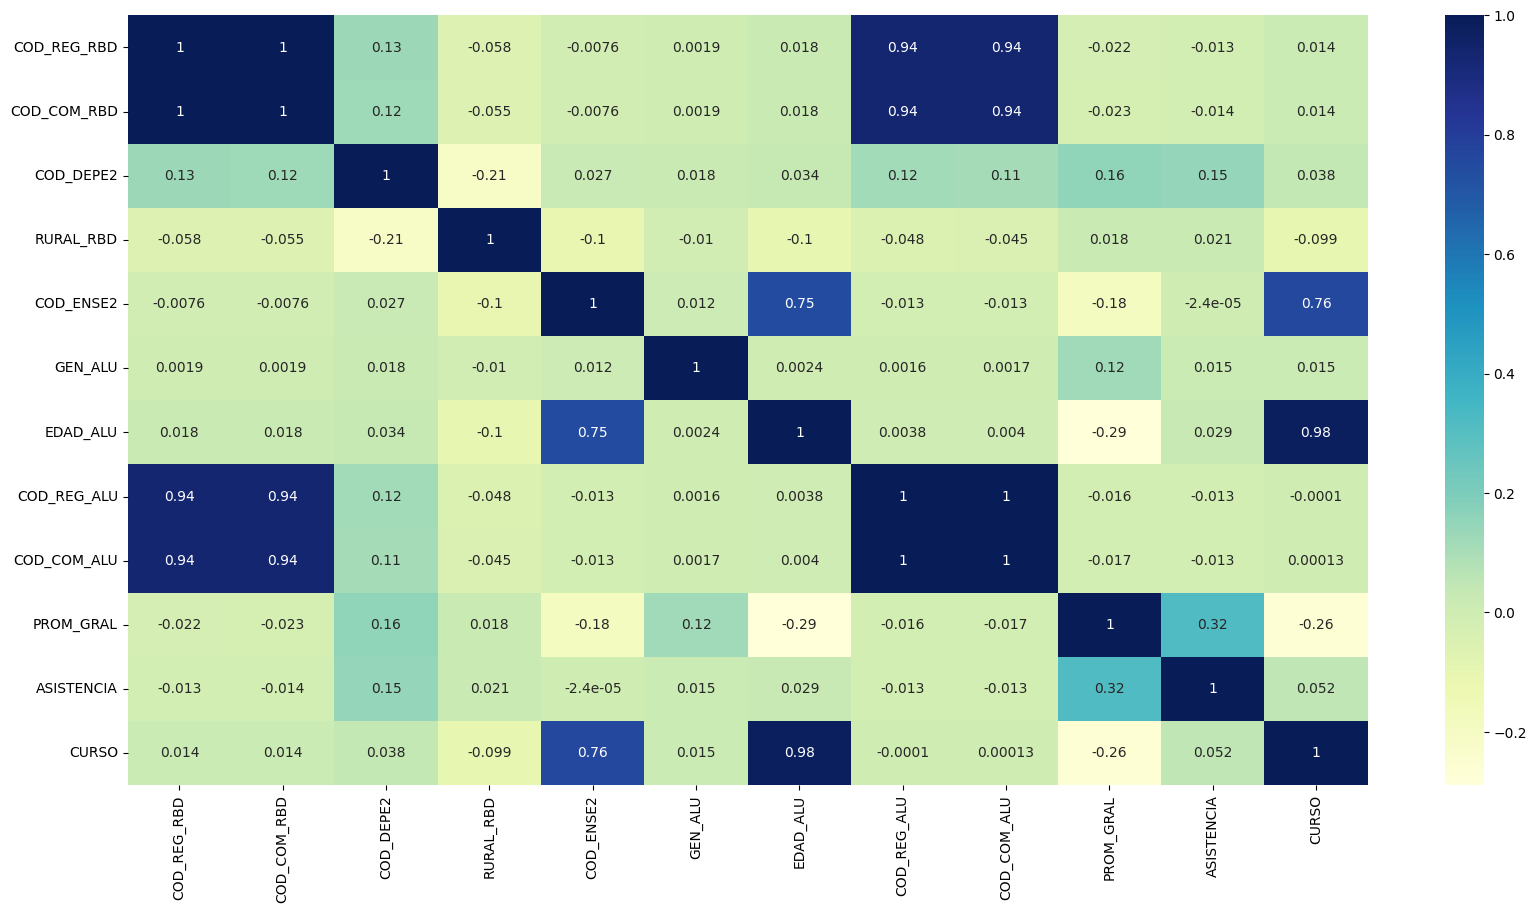

In [13]:
import seaborn as sb
import matplotlib.pyplot as plt

#Observar correlacion para hacer mas limpieza
plt.figure(figsize=(20,10))
sb.heatmap(data.corr(), annot=True, cmap='YlGnBu')

In [14]:
# División de datos
X = data.drop(columns=['PROM_GRAL'])
y = data['PROM_GRAL']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [15]:
# Normalización de datos
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
# random forest
from sklearn.ensemble import RandomForestRegressor
modelo = RandomForestRegressor(random_state=42, max_depth=30, n_estimators=150, min_samples_split=10, min_samples_leaf=4)
modelo.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=150, random_state=42)

In [17]:
# predicciones
y_pred = modelo.predict(X_test)

In [18]:
# aproximar el valor a 1 digito decimal de y_pred
y_pred = np.round(y_pred, decimals=1)
y_pred

array([6.5, 6.7, 6. , ..., 6.5, 5.8, 5.8])

In [19]:
# Métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MAE: ', mae)
print('MSE: ', mse)
print('R2: ', r2)

MAE:  0.39445298059876027
MSE:  0.2579012460549975
R2:  0.29203071114316514


In [21]:
Test = pd.DataFrame({'PROM_GRAL': y_test, 'GEN_ALU': X_test['GEN_ALU']})

plt.figure(figsize=(20,10))
sb.countplot(x='PROM_GRAL', data=Test, hue='GEN_ALU', palette='Set1')
plt.legend(["Masculino", "Femenino"])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

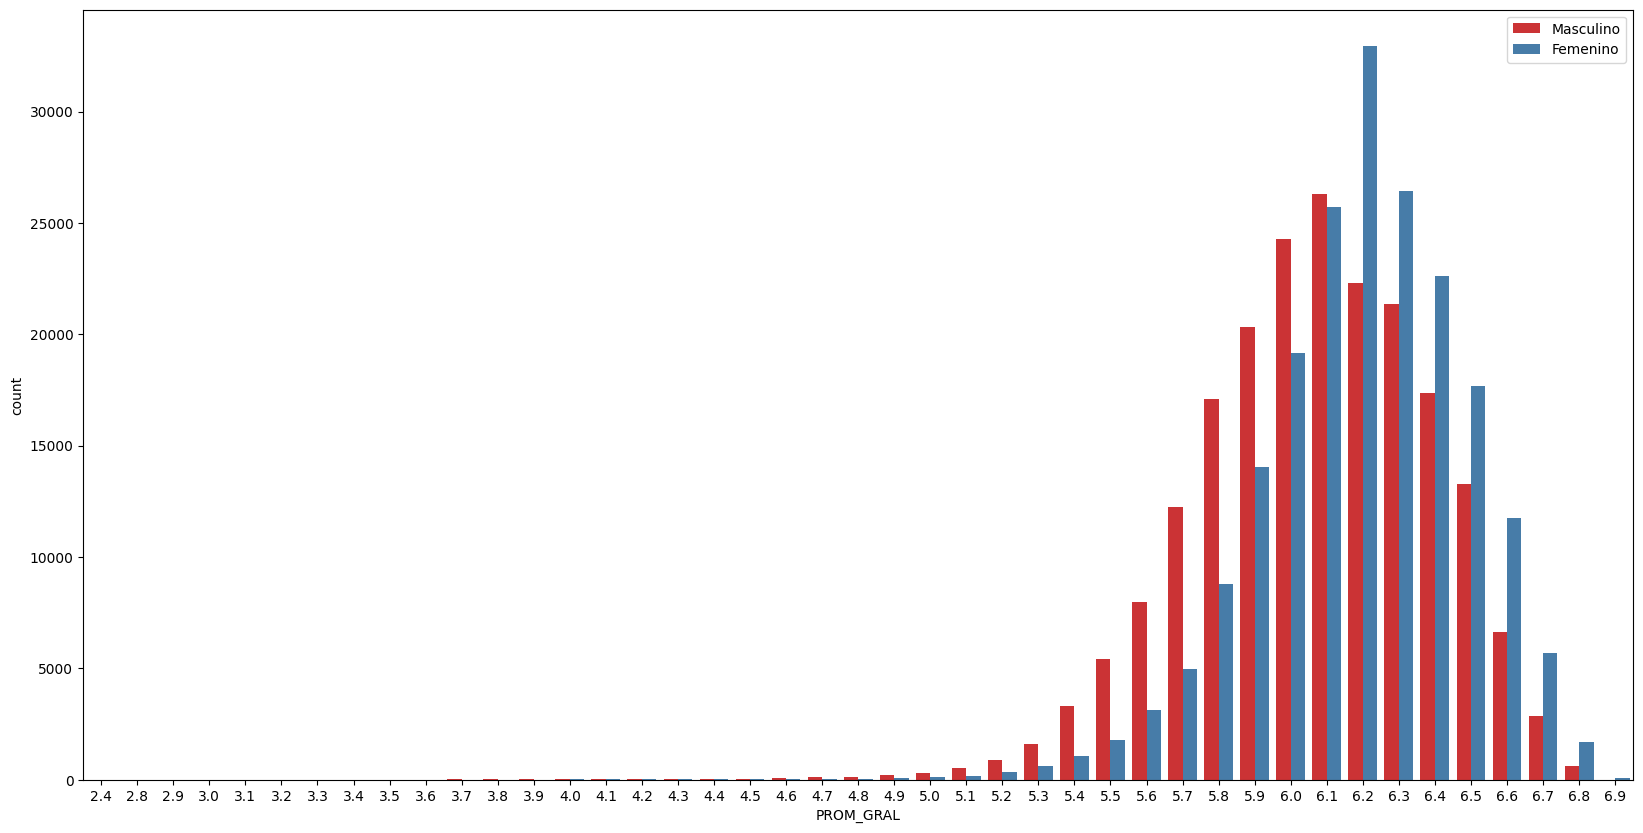

In [ ]:
Pred = pd.DataFrame({'PROM_GRAL': y_pred.flatten(), 'GEN_ALU': X_test['GEN_ALU']})

plt.figure(figsize=(20,10))
sb.countplot(x='PROM_GRAL', data=Pred, hue='GEN_ALU', palette='Set1')
plt.legend(["Masculino", "Femenino"])